NOMBRES: Mariel Alejandra   

APELLIDOS: Guamuche Recinos

CARNE: 21150

FECHA: 04/septiembre/2025

**Ejercicio 1**
Cree un corpus a su gusto como el visto en clase, cálcule PPMI, pero aplicando Lapace Smoothing.

In [1]:
import re
import numpy as np
from collections import Counter
import pandas as pd

def normalize_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-zñáéíóú0-9\s]", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return normalize_text(text).split()

def build_vocab(tokenized_docs, min_freq: int = 1):
    counts = Counter([t for doc in tokenized_docs for t in doc])
    vocab = [w for w, c in counts.items() if c >= min_freq]
    vocab = sorted(vocab)
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}
    return vocab, word2idx, idx2word, counts

def sliding_windows_indices(center, window_size, n):
    start = max(0, center - window_size)
    end = min(n, center + window_size + 1)
    return [i for i in range(start, end) if i != center]

def build_cooccurrence(tokenized_docs, word2idx, window_size=2, distance_weight=False):
    V = len(word2idx)
    M = np.zeros((V, V), dtype=float)
    for doc in tokenized_docs:
        n = len(doc)
        for i, w in enumerate(doc):
            wi = word2idx[w]
            for j in sliding_windows_indices(i, window_size, n):
                cj = word2idx[doc[j]]
                if distance_weight:
                    dist = abs(i - j)
                    M[wi, cj] += 1.0 / dist
                else:
                    M[wi, cj] += 1.0
    return M

def ppmi_laplace(C, alpha=1.0, eps=1e-12):
    """
    PPMI con suavizado de Laplace (add-alpha):
    p(w,c) = (C_wc + alpha) / (total + alpha * V^2)
    """
    V = C.shape[0]
    total = float(C.sum())
    denom = total + alpha * (V * V)
    Pwc = (C + alpha) / denom
    Pw = Pwc.sum(axis=1, keepdims=True)
    Pc = Pwc.sum(axis=0, keepdims=True)
    PMI = np.log((Pwc + eps) / (Pw @ Pc + eps))
    return np.maximum(PMI, 0.0)

def cosine_similarity_matrix(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / norms
    return Xn @ Xn.T

def top_k_neighbors(word, vocab, simM, k=5):
    if word not in vocab:
        return []
    i = vocab.index(word)
    row = simM[i].copy()
    row[i] = -np.inf
    idxs = np.argsort(-row)[:k]
    return [(vocab[j], float(row[j])) for j in idxs]

def compute_embeddings(PPMI, k=50):
    U, s, Vt = np.linalg.svd(PPMI, full_matrices=False)
    k = min(k, U.shape[1])
    E = U[:, :k] * s[:k]
    return E

def word_vec(word, vocab, E):
    if word not in vocab:
        return None
    return E[vocab.index(word)]

def most_similar_vec(vec, E, topn=5, exclude_idx=None):
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    En = E / norms
    vn = vec / (np.linalg.norm(vec) + 1e-12)
    sims = En @ vn
    if exclude_idx is not None:
        sims[exclude_idx] = -np.inf
    idxs = np.argsort(-sims)[:topn]
    return idxs, sims[idxs]

def analogy(a, b, c, vocab, E, topn=5):
    va, vb, vc = word_vec(a, vocab, E), word_vec(b, vocab, E), word_vec(c, vocab, E)
    if va is None or vb is None or vc is None:
        return []
    target = vb - va + vc
    idxs, sims = most_similar_vec(target, E, topn=topn + 5)
    forbids = {vocab.index(w) for w in [a, b, c] if w in vocab}
    results = []
    for idx, score in zip(idxs, sims):
        if idx not in forbids:
            results.append((vocab[idx], float(score)))
        if len(results) == topn:
            break
    return results

In [2]:
corpus_docs = [
    "el comeback de bts fue anunciado con un teaser y el mv rompió récords en youtube",
    "blackpink presentó su nuevo single y el fandom blink organizó un streaming masivo",
    "el idol practicó la coreografía en la sala de ensayo antes del stage en music show",
    "la agencia hybe confirmó el debut del nuevo grupo con un trailer y fotos conceptuales",
    "sm entertainment anunció gira mundial y un lightstick edición especial para el fandom",
    "jyp programó un dance practice y un live para celebrar el charting en billboard",
    "el maknae lideró el challenge de tiktok y la rap line preparó un remix",
    "la vocal line grabó armonías y el leader coordinó los ensayos para el escenario final",
    "el fandom army apoyó el comeback con proyectos y banners en el concierto",
    "yg publicó teasers del mv y la fecha de lanzamiento del album deluxe",
    "el showcase incluyó un medley y una sesión de firmas con los trainees",
    "la coreografía tiene killing parts y un puente vocal que se volvió viral",
    "el grupo ganó primer lugar en inkigayo y agradeció en el encore stage",
    "se anunció colaboración con un productor famoso y versiones acústicas del single",
    "el tour incluyó fechas en seúl tokio los ángeles y ciudad de méxico",
]

Coocurrencias (parcial):
            acústicas  agencia  agradeció  album  antes  anunciado  anunció  \
acústicas        0.0      0.0        0.0    0.0    0.0        0.0      0.0   
agencia          0.0      0.0        0.0    0.0    0.0        0.0      0.0   
agradeció        0.0      0.0        0.0    0.0    0.0        0.0      0.0   
album            0.0      0.0        0.0    0.0    0.0        0.0      0.0   
antes            0.0      0.0        0.0    0.0    0.0        0.0      0.0   
anunciado        0.0      0.0        0.0    0.0    0.0        0.0      0.0   
anunció          0.0      0.0        0.0    0.0    0.0        0.0      0.0   
apoyó            0.0      0.0        0.0    0.0    0.0        0.0      0.0   
armonías         0.0      0.0        0.0    0.0    0.0        0.0      0.0   
army             0.0      0.0        0.0    0.0    0.0        0.0      0.0   
banners          0.0      0.0        0.0    0.0    0.0        0.0      0.0   
billboard        0.0      0.0        0

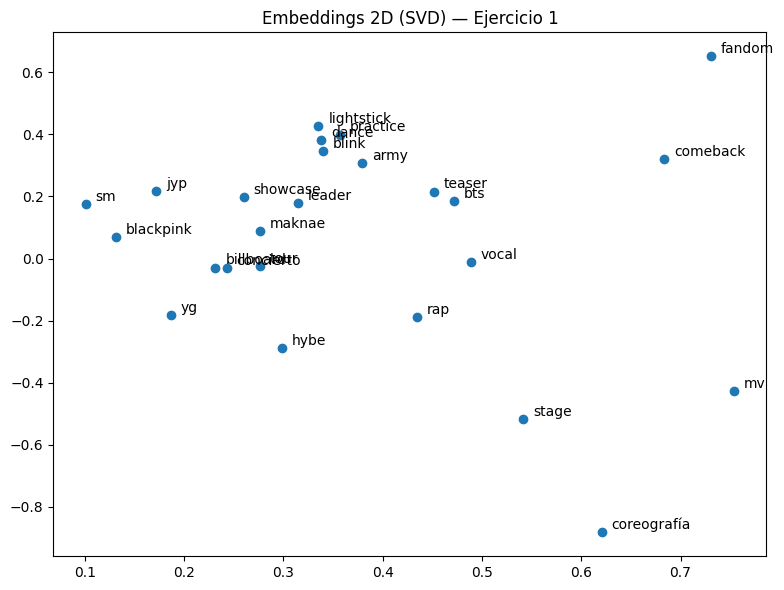

In [3]:
tokenized_docs = [tokenize(d) for d in corpus_docs]
vocab, word2idx, idx2word, counts = build_vocab(tokenized_docs, min_freq=1)

WINDOW = 3
C = build_cooccurrence(tokenized_docs, word2idx, window_size=WINDOW, distance_weight=False)
PPMI = ppmi_laplace(C, alpha=1.0)

cooc_df = pd.DataFrame(C, index=vocab, columns=vocab)
ppmi_df = pd.DataFrame(PPMI, index=vocab, columns=vocab)
print("Coocurrencias (parcial):\n", cooc_df.iloc[:12, :12])
print("\nPPMI+Laplace (parcial):\n", ppmi_df.iloc[:12, :12])

S = cosine_similarity_matrix(PPMI)
targets = ["bts", "blackpink", "fandom", "comeback", "idol", "mv", "lightstick", "hybe", "sm", "jyp"]
for t in targets:
    vecs = top_k_neighbors(t, vocab, S, k=5)
    print(f"\nVecinos de '{t}':")
    for w, s in vecs:
        print(f"  {w:>15s}\t{s:.3f}")

# Visualización 2D opcional
try:
    E2 = compute_embeddings(PPMI, k=2)
    words_to_plot = [
        "bts", "blackpink", "army", "blink", "fandom", "comeback", "teaser", "mv",
        "coreografía", "dance", "practice", "stage", "showcase", "billboard",
        "hybe", "sm", "jyp", "yg", "leader", "maknae", "vocal", "rap",
        "lightstick", "tour", "concierto"
    ]
    mask = [w in words_to_plot for w in vocab]
    coords = E2[mask]
    labels = [w for w in vocab if w in words_to_plot]
    if len(coords) > 0:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 6))
        plt.scatter(coords[:, 0], coords[:, 1])
        for (x, y), lab in zip(coords, labels):
            plt.text(x + 0.01, y + 0.01, lab)
        plt.title("Embeddings 2D (SVD) — Ejercicio 1")
        plt.tight_layout()    
        plt.show()            
except Exception as e:
    print("No se pudo generar la visualización 2D:", e)

**Ejercicio 2**

Crear 10 analigias validas basadas en su texto, tome en cuenta que es necesario utilizar el codigo visto en clase y ajuste su corpus para poder lograr obtener todas las analogias

In [4]:
# Refuerzo de relaciones (repeticiones para señal fuerte)
pairs = [
    "army es el fandom de bts",
    "blink es el fandom de blackpink",
    "hybe es la agencia de bts",
    "yg es la agencia de blackpink",
    "sm es la agencia de exo",
    "jyp es la agencia de straykids",
    "exol es el fandom de exo",
    "stay es el fandom de straykids",
    "teaser antecede al mv en un comeback",
    "trailer antecede al lanzamiento de un album",
    "un anuncio antecede al teaser y al trailer",
]
corpus_pairs = pairs * 6

extras = [
    "exo realizó un comeback y su fandom exol organizó un streaming masivo",
    "straykids lanzó un teaser y su fandom stay apoyó el mv con banners",
    "bts pertenece a hybe y blackpink pertenece a yg",
    "exo pertenece a sm y straykids pertenece a jyp",
]

corpus_docs = corpus_docs + corpus_pairs + extras

In [5]:
tokenized_docs = [tokenize(d) for d in corpus_docs]
vocab, word2idx, idx2word, counts = build_vocab(tokenized_docs, min_freq=1)

WINDOW = 3
C = build_cooccurrence(tokenized_docs, word2idx, window_size=WINDOW, distance_weight=False)
PPMI = ppmi_laplace(C, alpha=1.0)
E = compute_embeddings(PPMI, k=80)

tests = [
    ("straykids", "stay", "bts", "army"),
    ("bts", "army", "straykids", "stay"),
    ("jyp", "straykids", "sm", "exo"),
    ("sm", "exo", "jyp", "straykids"),
    ("yg", "blackpink", "hybe", "bts"),
    ("yg", "blackpink", "jyp", "straykids"),
    ("exo", "exol", "blackpink", "blink"),
    ("hybe", "bts", "sm", "exo"),
    ("exo", "sm", "straykids", "jyp"),
    ("teaser", "mv", "trailer", "anuncio"),
]

rows = []
for a, b, c, expected in tests:
    res = analogy(a, b, c, vocab, E, topn=5)
    top = res[0] if res else ("<sin_resultado>", float("nan"))
    rows.append({
        "a": a, "b": b, "c": c,
        "pred_top1": top[0], "score": float(top[1]) if res else float("nan"),
        "expected": expected, "ok": top[0] == expected,
        "top5": res
    })

df = pd.DataFrame(rows)    
df

,a,b,c,pred_top1,score,expected,ok,top5
0,straykids,stay,bts,army,0.879074,army,True,"[(army, 0.8790735248899273), (exol, 0.78829178..."
1,bts,army,straykids,stay,0.860908,stay,True,"[(stay, 0.8609076237586204), (blink, 0.8047873..."
2,jyp,straykids,sm,exo,0.865680,exo,True,"[(exo, 0.865679669026024), (blackpink, 0.82372..."
3,sm,exo,jyp,straykids,0.856075,straykids,True,"[(straykids, 0.8560751158918598), (bts, 0.8278..."
4,yg,blackpink,hybe,bts,0.854837,bts,True,"[(bts, 0.8548374529766601), (straykids, 0.8494..."
5,yg,blackpink,jyp,straykids,0.822606,straykids,True,"[(straykids, 0.8226057398025817), (bts, 0.8223..."
6,exo,exol,blackpink,blink,0.821615,blink,True,"[(blink, 0.8216153204633025), (stay, 0.7869349..."
7,hybe,bts,sm,exo,0.818347,exo,True,"[(exo, 0.8183471063318716), (blackpink, 0.8019..."
8,exo,sm,straykids,jyp,0.818039,jyp,True,"[(jyp, 0.8180394372200286), (hybe, 0.799993248..."
9,teaser,mv,trailer,anuncio,0.549651,anuncio,True,"[(anuncio, 0.5496512963693945), (y, 0.34683255..."
